In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
CKPT_PATH = '../weights/checkpoints/2024_4_10_ALL_ON.ckpt'
DS_PATH = '../../GeneratedNusc/'
LOAD_MISSING = False
EVAL_OUTPUT_DIR = './outputs/'

In [4]:
import torch
import numpy as np
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def show(array):
    array = torch.tensor(array)    
    if isinstance(array, torch.Tensor):
        plt.figure(figsize = (32,9))
        plt.grid(False)
        # (-1, 1)
        if array.min() < 0:
            array = ((array + 1) * 127.5).to(torch.uint8)
        # (0, 1)
        elif array.max() <= 1:
            array = (array * 255).to(torch.uint8)
            
        elif array.dtype is not torch.uint8:
            array = array.to(torch.uint8)
        
        if len(array.shape) == 3 and array.shape[-1] not in [3, 1]:
            array = array.permute([1, 2, 0])
        
        plt.imshow(array.numpy())
        return
    
    plt.figure(figsize = (32,9))
    plt.grid(False)
    plt.imshow(array)

In [5]:
class RawNuscDS(torch.utils.data.Dataset):
    def __init__(self, base_root, csv_filename, lazy=False):
        super().__init__()
        self.base_root = base_root
        self.csv_data = pd.read_csv(base_root + csv_filename)
        self.cam_list = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_RIGHT', 'CAM_BACK', 'CAM_BACK_LEFT']
    
    def __getitem__(self, idx):
        path = self.base_root + self.csv_data.loc[idx]['filepath']
        data =  torch.load(path)
        return data, path
        
    def __len__(self):
        return len(self.csv_data)

In [6]:
raw_ds = RawNuscDS(DS_PATH, csv_filename='valid.csv')

In [7]:
# filter out small objs 
# overall num_obj <= 4,  ≈ 99.6%
# obj=1, 64.5%  <-> 80 Samples
# obj=2, 25.2% <-> 40 Smaples
# obj=3, 7.9% <-> 20 Samples
# obj=4, 2.4% <-> 10 Samples

## *Color Platte* 

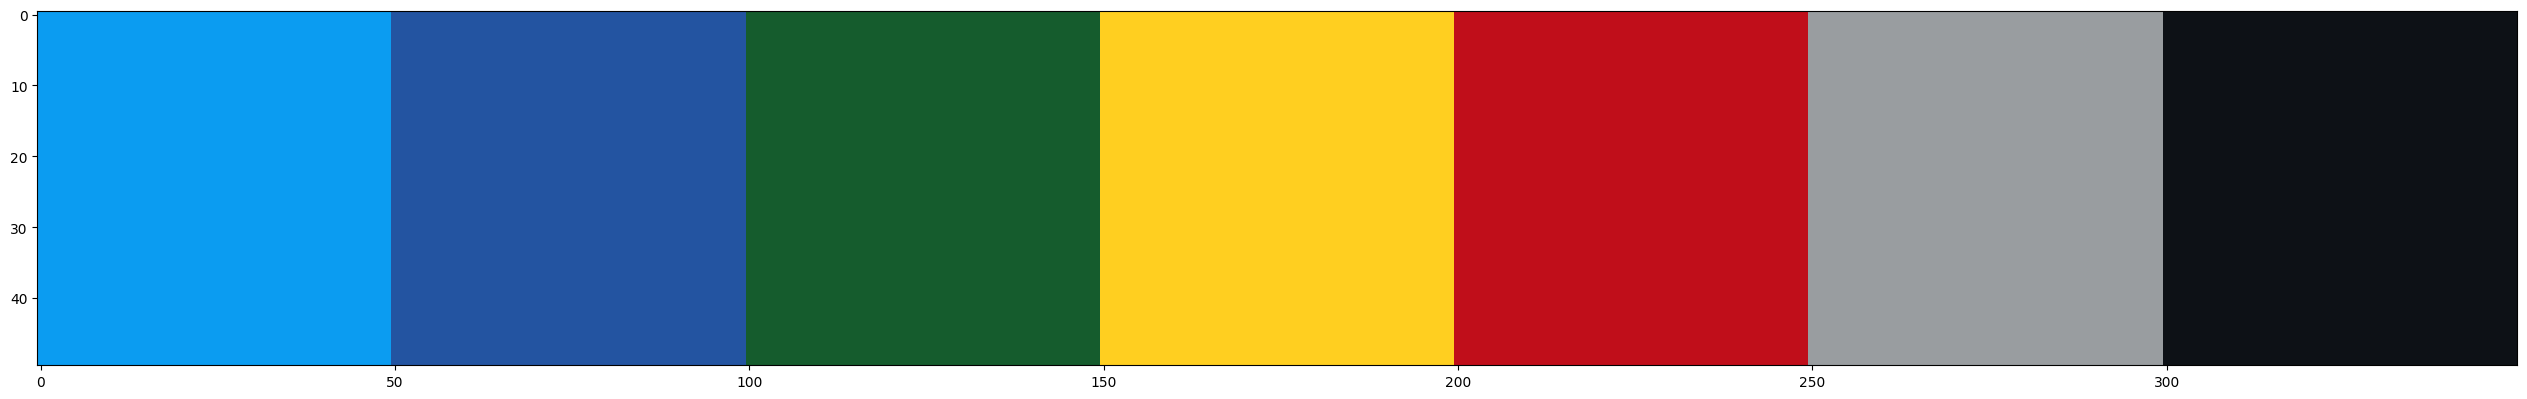

In [8]:
# from https://wiki.rage.mp/index.php?title=Vehicle_Colors
color_palte = dict(
    blue=(11, 156, 241),
    deep_blue=(35, 84, 161),
    green=(21, 92, 45),
    yellow=(255, 207, 32),
    red=(192, 14, 26),
    silver=(153, 157, 160),
    black=(13, 17, 22),
)
show(np.concatenate([np.ones((50, 50, 3), dtype=np.uint8) * np.array(value)[None, None] for value in color_palte.values()], axis=1))

In [9]:
# intstall colour lib, uncomment following line and run ↓
# !pip install colour-science
import colour

def get_n_unique_color(n: int):
    return random.sample(color_palte.keys(), n)

def compute_delta_E(rgb_color_a: np.ndarray, rgb_color_b: np.ndarray, drop_L=False):
    _lab_color_a = cv2.cvtColor((rgb_color_a[None, None] / 255.0).astype(np.float32), cv2.COLOR_RGB2Lab)
    _lab_color_b = cv2.cvtColor((rgb_color_b[None, None] / 255.0).astype(np.float32), cv2.COLOR_RGB2Lab)
    
    if drop_L:
        _lab_color_a[:, :, 0] = _lab_color_b[:, :, 0]

    return colour.difference.delta_E(_lab_color_a, _lab_color_b)

In [10]:
compute_delta_E(np.array([0, 0, 225]), np.array([0, 0, 139]), drop_L=True), \
compute_delta_E(np.array([0, 0, 225]), np.array([0, 0, 139]), drop_L=False)

(6.4409503987362164, 11.243957070938608)

## *Prepare Extra-Obj Prompts & Mask*

In [11]:
# find all scene -> view that contains objects in [1, 2, 3, 4]
test_scenes = {1: [], 2: [], 3: [], 4: [],}

with tqdm(total=len(raw_ds)) as t_bar:
    for i in range(len(raw_ds)):
        data = raw_ds[i][0]
        for cam in raw_ds.cam_list:
            num_cars = 0
            anns = data[cam]['annotations']
            boxes = []
            non_overlap_map = np.ones((900, 1600))
            for i, is_car in enumerate(list(map(lambda x: 'car' in x.split('.'), anns['labels']))):
                if is_car:
                    box = anns['boxes'][i]
                    for i, max_coord in zip(range(len(box)), [1600, 900, 1600, 900]):
                        box[i] = min(max(box[i], 0), max_coord)
                    
                    box_area = (box[3] - box[1]) * (box[2] - box[0])
                    if box_area > 57600 and non_overlap_map[box[1]: box[3], box[0]: box[2]].mean() > 0.75:
                        num_cars += 1
                        boxes.append(box)
                        non_overlap_map[box[1]: box[3], box[0]: box[2]] = 0
            if 4 >= num_cars > 0:
                test_scenes[num_cars].append({
                    'token': data['token'],
                    'camera': cam,
                    'boxes': sorted(list(boxes), key=lambda x: (x[3] - x[1]) * (x[2] - x[0]), reverse=True)[:num_cars]
                })
        t_bar.update(1)

  0%|          | 0/2022 [00:00<?, ?it/s]

In [12]:
def mean_box_area(boxes):
    return sum([((box[3] - box[1]) * (box[2] - box[0])).item() for box in boxes]) / len(boxes)

def min_box_area(boxes):
    return min([((box[3] - box[1]) * (box[2] - box[0])).item() for box in boxes])

for i in range(1, 5):
    test_scenes[i].sort(key=lambda x: min_box_area(x['boxes']),  reverse=True)

In [13]:
if LOAD_MISSING:
    from create_dataset import nuscenes_dataset
    from create_dataset import config
    nusc_ds = nuscenes_dataset(config)

def load_missing_data_from_nusc(token):
    return nusc_ds.get_data(data=dict(token=token))
    
def load_from_token(token):
    try:
        data = torch.load(os.path.join(DS_PATH, F'data/{token}.pt'))
    except FileNotFoundError:
        if LOAD_MISSING:
            data = load_missing_data_from_nusc(token)
        else:
            data = None
    finally:
        return data

def get_all_view_level(scene):
    n_cars = len(scene['boxes'])
    n_colors = get_n_unique_color(n_cars)
    prompts = [f'A car that is colored {color}.' for color in n_colors]
    obj_maskes = []
    data = load_from_token(scene["token"])
    if data is None:
        return data
    
    semantic_map = data[scene['camera']]['objects']['semantic_map']
    for box in scene['boxes']:
        f_h, f_w = 256 / 900, 448 / 1600
        box = np.array([box[0] * f_w, box[1] * f_h, box[2] * f_w, box[3] * f_h]).astype(np.int64)
        _mask = np.zeros((256, 448, 1))
        _mask[box[1]: box[3], box[0]: box[2]] = (semantic_map[box[1]: box[3], box[0]: box[2]] == 13)[:, :, None]
        obj_maskes.append(_mask)
    
    return dict(obj_mask=obj_maskes, obj_prompt=prompts, colors=n_colors, num_objs=n_cars, camera=scene['camera'])

def prepare_all_scene_level(scene):
    MASK_SHAPE = (6, 256 // 8, 448 // 8, 4)
    # pad all anns to 4-objs
    view_data = get_all_view_level(scene)
    empty_data = dict(
        obj_mask=np.zeros(MASK_SHAPE), 
        obj_prompt=[['', '', '', ''],] * 6,
        colors=[''],
        num_objs=0,
        camera='CAM_FRONT', # useless filling value here.
    )
    if view_data is None:
        print('Empty data is returned, because of selected data is missing.')
        return empty_data
    
    num_objs = view_data['num_objs']
    idx = raw_ds.cam_list.index(scene['camera'])
    empty_data['obj_mask'][idx] = np.stack(
        [cv2.resize(view_data['obj_mask'][i].astype(np.uint8), dsize=(448 // 8, 256 // 8)) for i in range(num_objs)] + \
         [np.zeros((256 // 8, 448 // 8)) for j in range(4 - num_objs)], axis=-1)

    empty_data['obj_prompt'][idx] = view_data['obj_prompt'] + ['' for i in range(4 - num_objs)]    
    empty_data['colors'] = view_data['colors']
    empty_data['num_objs'] = view_data['num_objs']
    empty_data['camera'] = view_data['camera']
    
    return empty_data

## *Explore data*

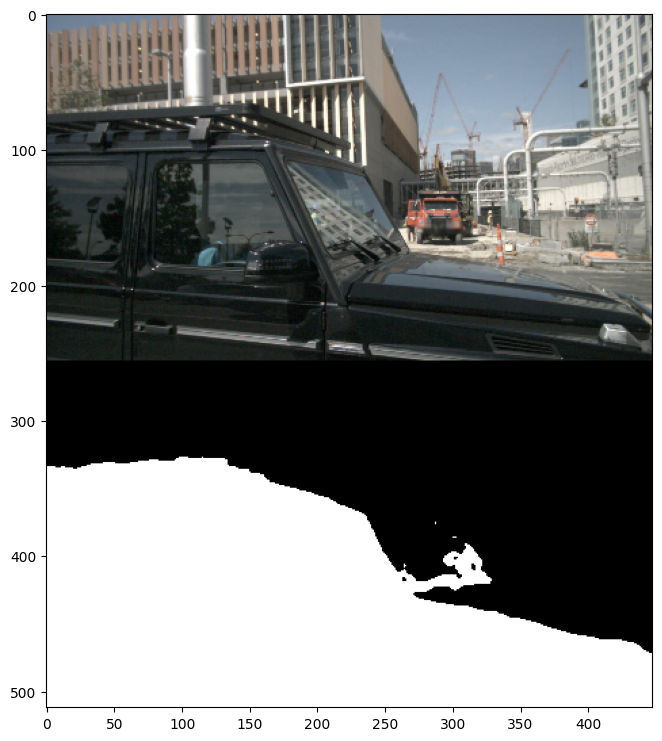

In [14]:
n_obj = 1
i = 0
img = load_from_token(test_scenes[n_obj][i]['token'])[test_scenes[n_obj][i]['camera']]['rgb_image']
show(
    np.concatenate([
        np.concatenate([img for i in range(n_obj)], axis=1),
        np.concatenate([mask for mask in get_all_view_level(test_scenes[n_obj][i])['obj_mask']], axis=1).repeat(3, axis=-1) * 255
    ], axis=0)
)

## *Creat Multi-Obj control DS*

In [15]:
import json
from configs import test_config as cfg
from src.dataset import GeneratedNuscDS

In [16]:
class MultiObjDS(GeneratedNuscDS):
    
    def __getitem__(self, idx):
        _, path, cam_id, boxes = self.csv_data.loc[idx]
        token = path.split('/')[-1].split('.')[0]
        boxes = [np.array(json.loads(boxes)[0])]
        
        prompted_objs = prepare_all_scene_level(dict(boxes=boxes, token=token, camera=cam_id))
        
        try:
            data = super().__getitem__(idx)
        except FileNotFoundError:
            if LOAD_MISSING:
                data = super().__getitem__(load_missing_data_from_nusc(token))
            else:
                data = ds.get_empty_data()
        
        data['prompted_objs'] = prompted_objs
        return data

In [17]:
ds = MultiObjDS(cfg.dataset['valid'])
# for reproducing, test sample we selected (we filter out overlaping objects and control test sample numbers)
# we provided those samples we used. However, because of the version of dataset (generated from NuScenes, which
# is a subset of NuScenes), some samples did not exists in this version (if you followed the default setup and 
# created your dataset). To make them up, a "LOAD_MISSING" option is provided. enable it you can load them from NuScenes
# (the cost is it takes extra time). Or you can ignore it anyway, the code will not crashed, instead, empty data
# will be placed in.
# Well, in other hand, it is unnecessary to use those samples we used. you can simple build a similar dataframe to
# deal with those existing data in your dataset as we've already found above. like:
# """
# your_df = DataFrame()
# your_df['filepath'] = ...， your_df['cam_id'] = ..., your_df['boxes'] = ...
# ds.csv_data = your_df
# """
ds.csv_data = pd.read_csv('./selected_views.csv')

In [18]:
def collate_fn(datas):
    images = torch.tensor(np.stack([data['images'] for data in datas], axis=0))
    semantics = torch.tensor(np.stack([data['semantics'] for data in datas], axis=0))
    prompt = [data['prompt'] for data in datas]
    homos = torch.stack([data['homos'] for data in datas], dim=0)
    image_paths = [data['image_paths'] for data in datas]
    scene_id = [data['scene_id'] for data in datas]
    token = [data['token'] for data in datas]
    boxes = [data['boxes'] for data in datas]
    prompted_objs = {
        'obj_mask': torch.tensor(np.stack([data['prompted_objs']['obj_mask'] for data in datas]).astype(np.float32)),
        'obj_prompt': [data['prompted_objs']['obj_prompt'] for data in datas],
        'colors': [data['prompted_objs']['colors'] for data in datas],
        'num_objs': [data['prompted_objs']['num_objs'] for data in datas],
        'camera': [data['prompted_objs']['camera'] for data in datas],
    }
    
    fore_mask = torch.tensor(np.stack([data['foreground_mask'][:, None, :, :] for data in datas], axis=0))
    control_mask = {
        'raw': torch.tensor(np.stack([data['seman_control_mask']['raw'][:, None] for data in datas], axis=0)),
        '1x': torch.tensor(np.stack([data['seman_control_mask']['1x'][:, None] for data in datas], axis=0)),
        '2x': torch.tensor(np.stack([data['seman_control_mask']['2x'][:, None] for data in datas], axis=0)),
        '4x': torch.tensor(np.stack([data['seman_control_mask']['4x'][:, None] for data in datas], axis=0)),
        '8x': torch.tensor(np.stack([data['seman_control_mask']['8x'][:, None] for data in datas], axis=0)),
    }

    return {
        'images': images,
        'semantics': semantics,
        'prompt': prompt,
        'homos': homos,
        'boxes': boxes,
        'prompted_objs': prompted_objs,
        'image_paths': image_paths,
        'scene_id': scene_id,
        'token': token,
        'foreground_mask': fore_mask,
        'seman_control_mask': control_mask
    }

In [19]:
dl = torch.utils.data.DataLoader(
        ds, batch_size=4, shuffle=False, num_workers=0, drop_last=False, collate_fn=collate_fn)

In [20]:
data = next(iter(dl))

Empty data is returned, because of selected data is missing.


In [21]:
# load model
from src.models import MultiViewLDM
model = MultiViewLDM(cfg.model)
model.load_state_dict(torch.load(CKPT_PATH, map_location='cuda')['model'], strict=False)
model = model.to('cuda')
model.enforce_overlaps = False

In [22]:
def to_device(target, device='cuda'):
    # move data to device by recursion
    if isinstance(target, torch.Tensor):
        return target.cuda()

    elif isinstance(target, dict):
        for k in target.keys():
            target[k] = to_device(target[k], device)
    elif isinstance(target, list):
        for ele in target:
            ele = to_device(ele, device)
    return target

In [24]:
%%time
data = to_device(data)
res = model.inference(data)

CPU times: user 2min 33s, sys: 712 ms, total: 2min 33s
Wall time: 2min 23s


/tmp/ipykernel_5054/616635361.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  array = torch.tensor(array)


[['', '', '', ''],
 ['', '', '', ''],
 ['A car that is colored red.', '', '', ''],
 ['', '', '', ''],
 ['', '', '', ''],
 ['', '', '', '']]

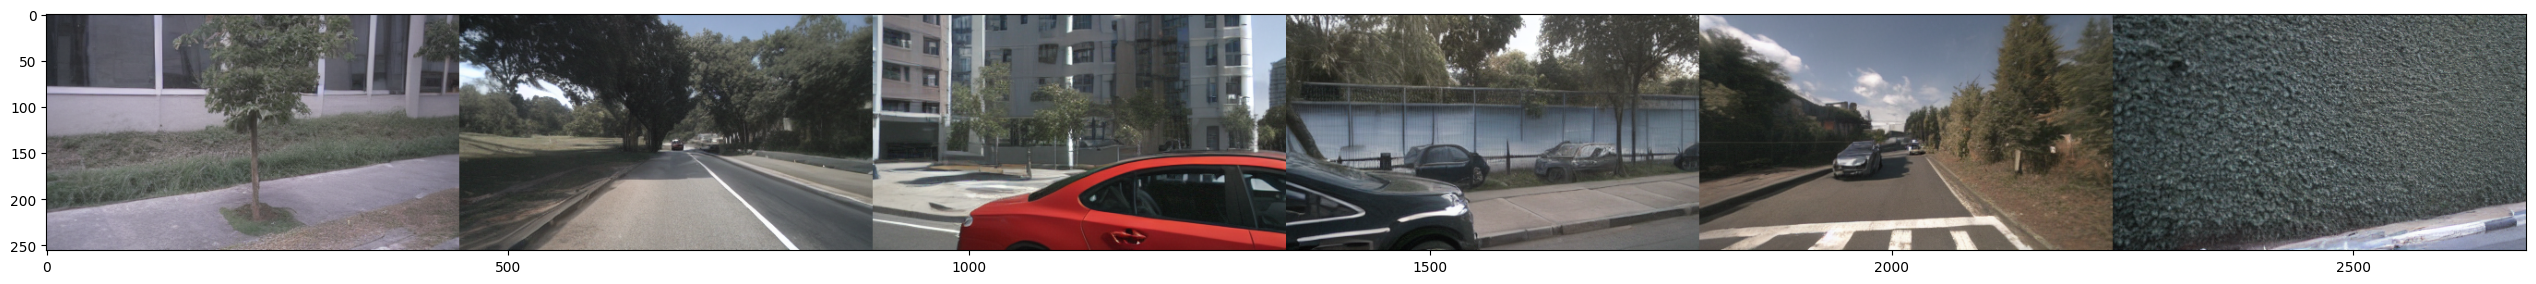

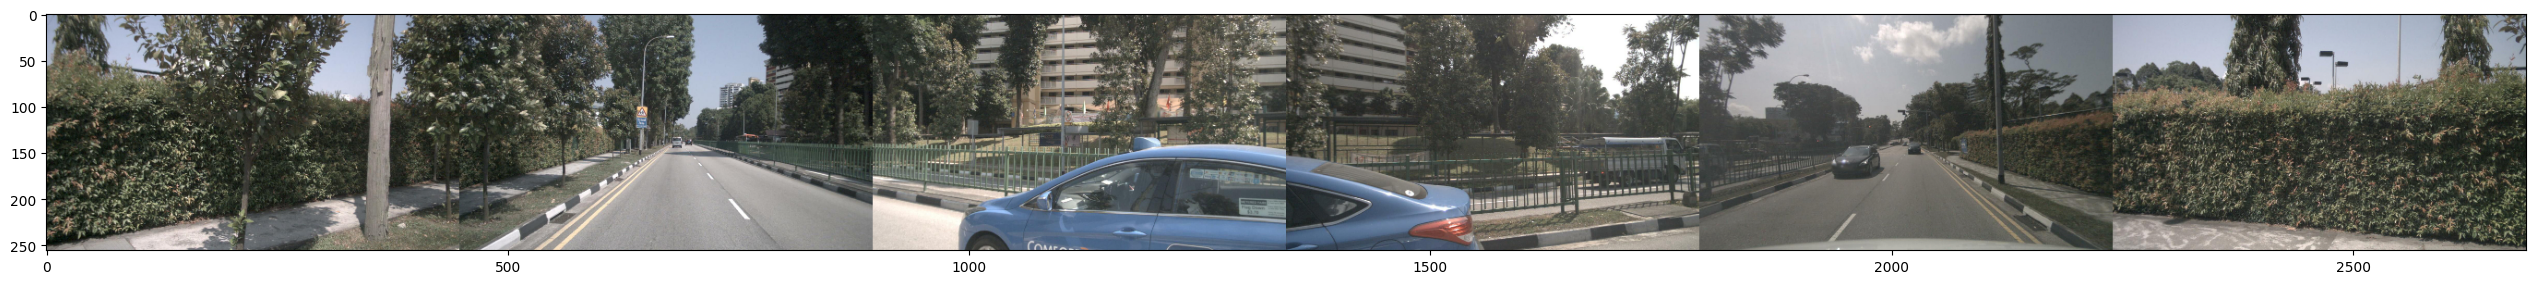

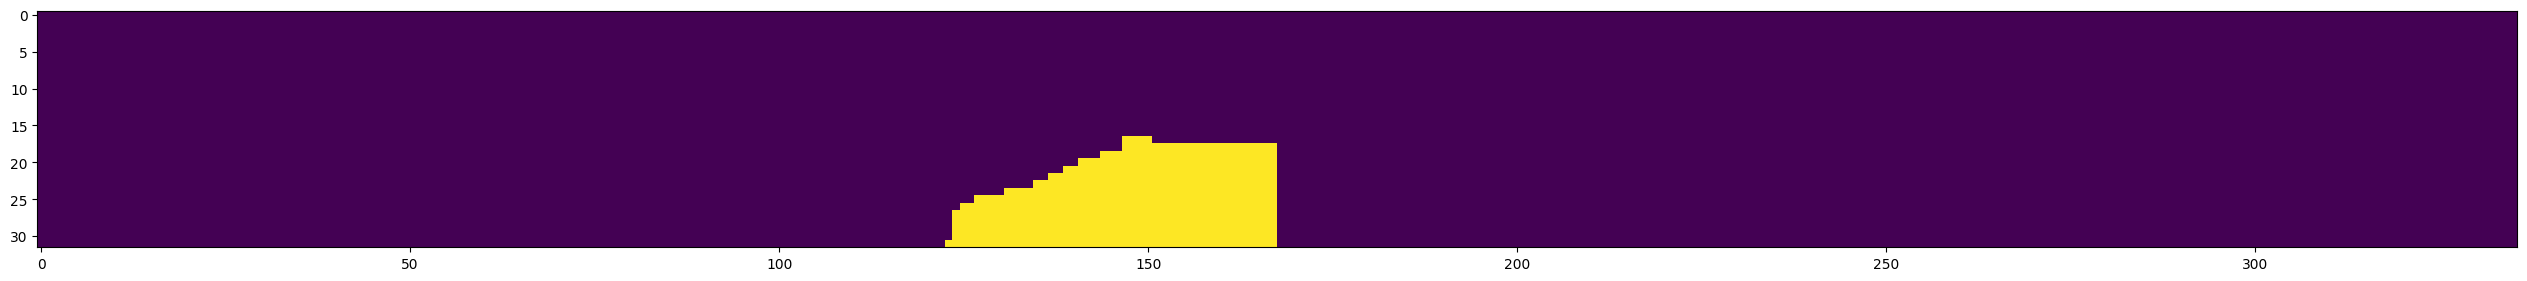

In [25]:
i = 0
show(np.concatenate([res[i][_] for _ in range(6)], axis=1))
show(torch.concat([data['images'][i][_].cpu() for _ in range(6)], axis=1))
show(torch.concat([data['prompted_objs']['obj_mask'][i][_][:, :, 0].cpu() for _ in range(6)], axis=1))
data['prompted_objs']['obj_prompt'][i]

## *Evaluate*

In [26]:
import torch.nn.functional as F
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric

# customized distance_func for clustering
delta_E_dist = distance_metric(type_metric.USER_DEFINED, func=compute_delta_E)


def mean_rgb_color(image, mask, expect_color='black'):

    x_coord, y_coord = np.where(mask == 1)
    target_points = image[x_coord, y_coord]# .reshape(-1)
    
    if expect_color == 'black':
        start_centers = [[0, 0, 0], [255, 255, 255]]
    elif expect_color == 'silver':
        start_centers = [[255, 255, 255], [0, 0, 0]]
    else:
        start_centers = [color_palte[expect_color], [0, 0, 0], [255, 255, 255]]
        
    kmeans_instance = kmeans(target_points, start_centers,  metric=delta_E_dist)

    # run cluster analysis and obtain results
    kmeans_instance.process()
    return kmeans_instance._kmeans__centers[0]


global_cnt = 0

def metric(pred, anns):
    # pred: 6 view
    # anns: ...
    colorwise_delta_E = {k: [] for k in color_palte.keys()}
    obj_num_wise_delta_E = {i + 1: [] for i in range(4)}
    
    colorwise_acc = {k: [] for k in color_palte.keys()}
    obj_num_wise_acc = {i + 1: [] for i in range(4)}
    
    for i in range(pred.shape[0]):
        camera = anns['camera'][i]
        cam_idx = raw_ds.cam_list.index(camera)
        colors =  anns['colors'][i]
        pred_view = cv2.resize(pred[i][cam_idx], dsize=(448 // 8, 256 // 8))
        for obj_idx in range(anns['num_objs'][i]):

            color_by_name = colors[obj_idx]
            color = np.array(color_palte[color_by_name])
            
            mask = anns['obj_mask'][i][cam_idx][:, :, obj_idx].cpu().numpy()
            # fillter out samll objs
            if mask.sum() < 50:
                continue
             
            ######################
            # save results
            img = pred[i][cam_idx][:, :, [2, 1, 0]] # to BGR
            _mask = cv2.resize(mask.astype(np.uint8), dsize=(448, 256))[:, :, None]
            color_mask = _mask * color[None, None][:, :, [2, 1, 0]] + (1 - _mask) * np.array([255, 255, 255])[None, None]
            global global_cnt, img_id, expect_color
            cv2.imwrite(f'{EVAL_OUTPUT_DIR}IMG_{global_cnt}.jpg', np.concatenate([img, color_mask], axis=0))            
            global_cnt += 1
            ######################

            drop_L = not color_by_name in ['black', 'silver']
            
            mean_color = mean_rgb_color(pred_view, mask, expect_color=color_by_name)
            delta_E = compute_delta_E(color, mean_color, drop_L=drop_L)

            colorwise_delta_E[color_by_name].append((delta_E, mean_color))
            obj_num_wise_delta_E[anns['num_objs'][i]].append((delta_E, mean_color))
            
    return colorwise_delta_E, obj_num_wise_delta_E

# *Run it!*

In [27]:
colorwise_res = {k: [] for k in color_palte.keys()}
obj_num_wise_res = {i + 1: [] for i in range(4)}
preds = []
datas = []

with tqdm(total=len(dl)) as t_at:
    for data in dl:
        data = to_device(data, 'cuda')
        datas.append(data)
        pred = model.inference(data)
        preds.append(pred)
        res_a, res_b = metric(pred, data['prompted_objs'])
        for k in res_a:
            colorwise_res[k] += res_a[k]
        for k in res_b:
            obj_num_wise_res[k] += res_b[k]
        t_at.update(1)

  0%|          | 0/38 [00:00<?, ?it/s]

Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, because of selected data is missing.
Empty data is returned, 

In [56]:
def evaluate(preds, datas):
    colorwise_delta_E = {k: [] for k in color_palte.keys()}
    obj_num_wise_delta_E = {i + 1: [] for i in range(4)}
    
    colorwise_acc = {k: [] for k in color_palte.keys()}
    obj_num_wise_acc = {i + 1: [] for i in range(4)}
    for pred, data in zip(preds, datas):
        res_a, res_b = metric(pred, data['prompted_objs'])
        for k in res_a:
            colorwise_delta_E[k] += res_a[k]
        for k in res_b:
            obj_num_wise_delta_E[k] += res_b[k]

    return colorwise_delta_E, obj_num_wise_delta_E

In [132]:
colorwise_delta_E, obj_num_wise_delta_E = evaluate(preds, datas)

blue mean Delta E: 10.511277480919079
deep_blue mean Delta E: 8.900022124284941
green mean Delta E: 9.300056722124207
yellow mean Delta E: 13.90217215325953
red mean Delta E: 14.454130401488282
silver mean Delta E: 9.429664184895183
black mean Delta E: 6.441790531586529


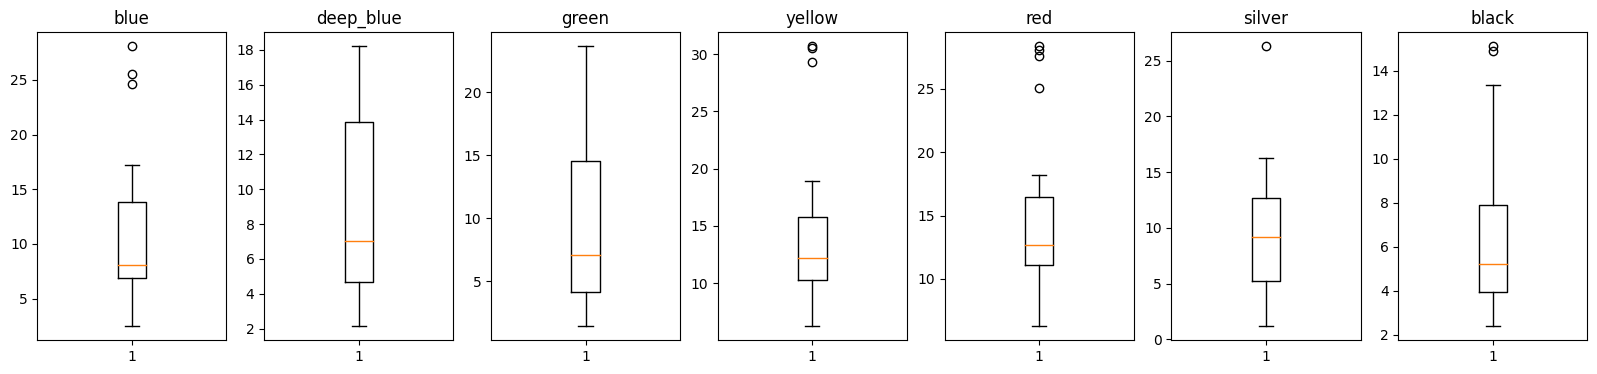

In [103]:
for i, key in enumerate(colorwise_res.keys()):
    print(f'{key} mean Delta E: {sum(colorwise_res[key]) / len(colorwise_res[key])}')

/tmp/ipykernel_884/1438348020.py:2: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(colorwise_res,fill=True, palette=np.array([list(c) + [10] for c in list(color_palte.values())]) / 255, order=['black', 'silver', 'blue', 'deep_blue', 'green', 'yellow', 'red'], showfliers=False, gap=.3, linecolor=[60 / 255, 60 / 255, 60 / 255])


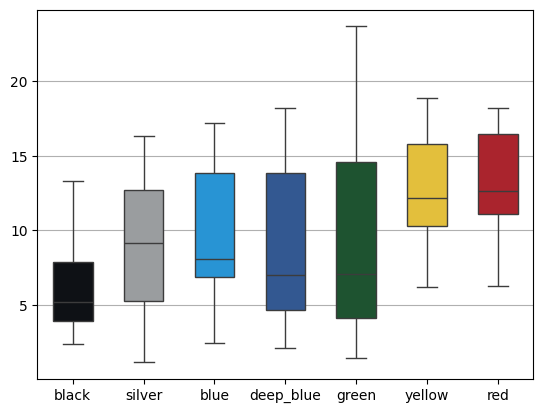

In [197]:
plt.grid()
sns.boxplot(colorwise_res,fill=True, palette=np.array([list(c) + [10] for c in list(color_palte.values())]) / 255, order=['black', 'silver', 'blue', 'deep_blue', 'green', 'yellow', 'red'], showfliers=False, gap=.3, linecolor=[60 / 255, 60 / 255, 60 / 255])

/tmp/ipykernel_70377/2074407173.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  array = torch.tensor(array)


[['', '', '', ''],
 ['', '', '', ''],
 ['A car that is colored red.', 'A car that is colored blue.', '', ''],
 ['', '', '', ''],
 ['', '', '', ''],
 ['', '', '', '']]

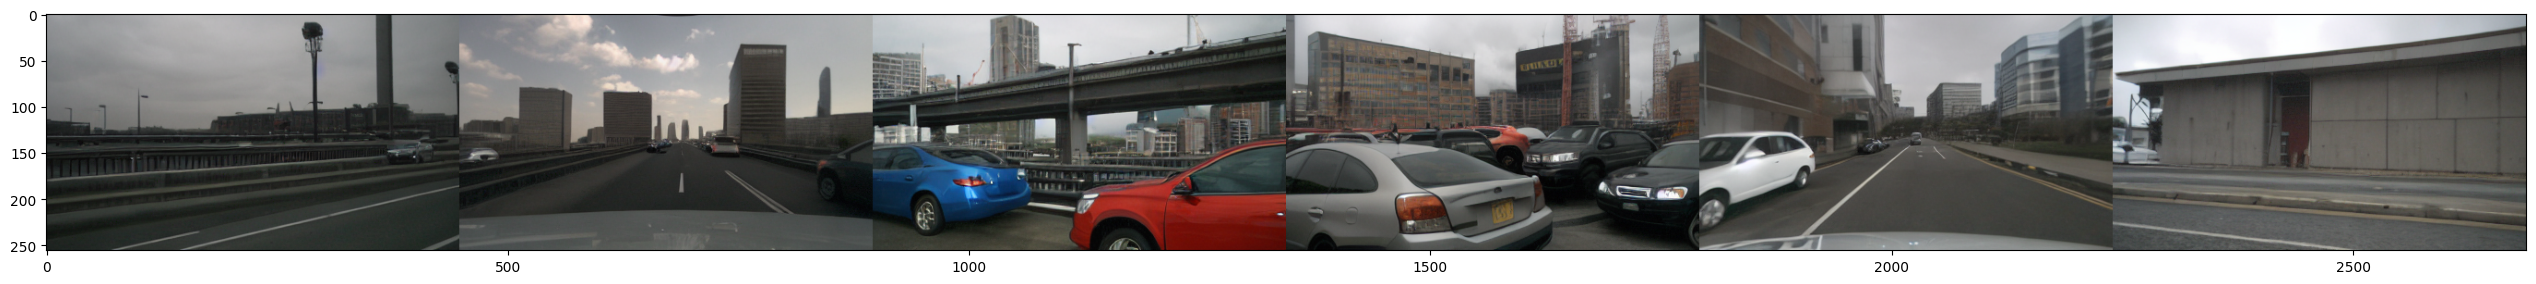

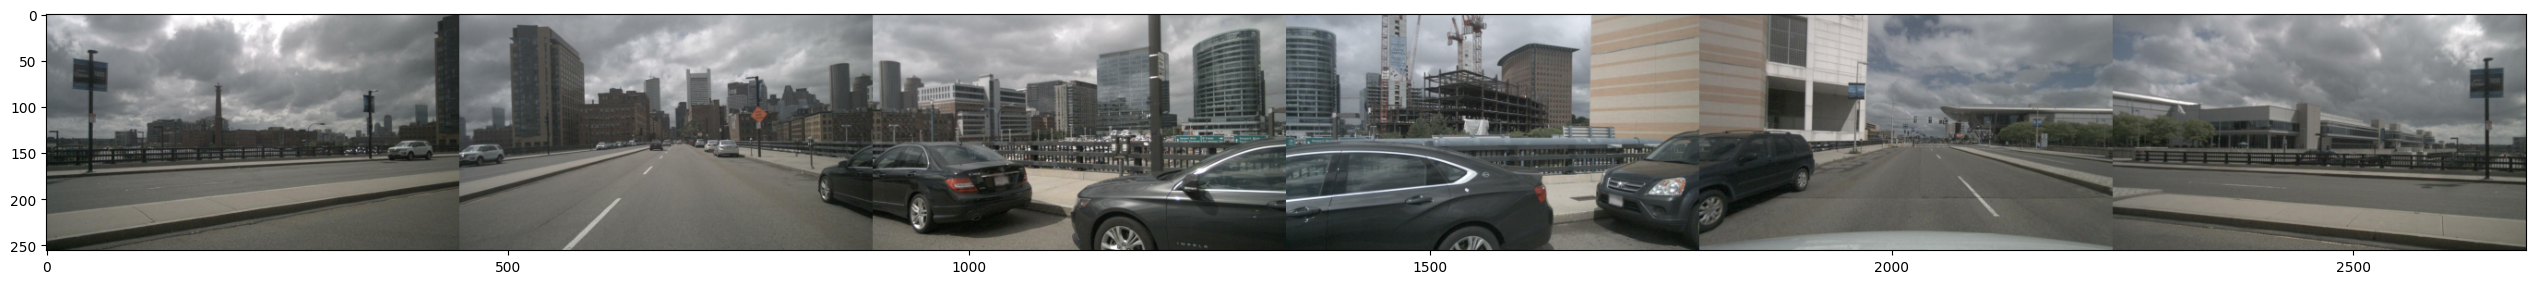

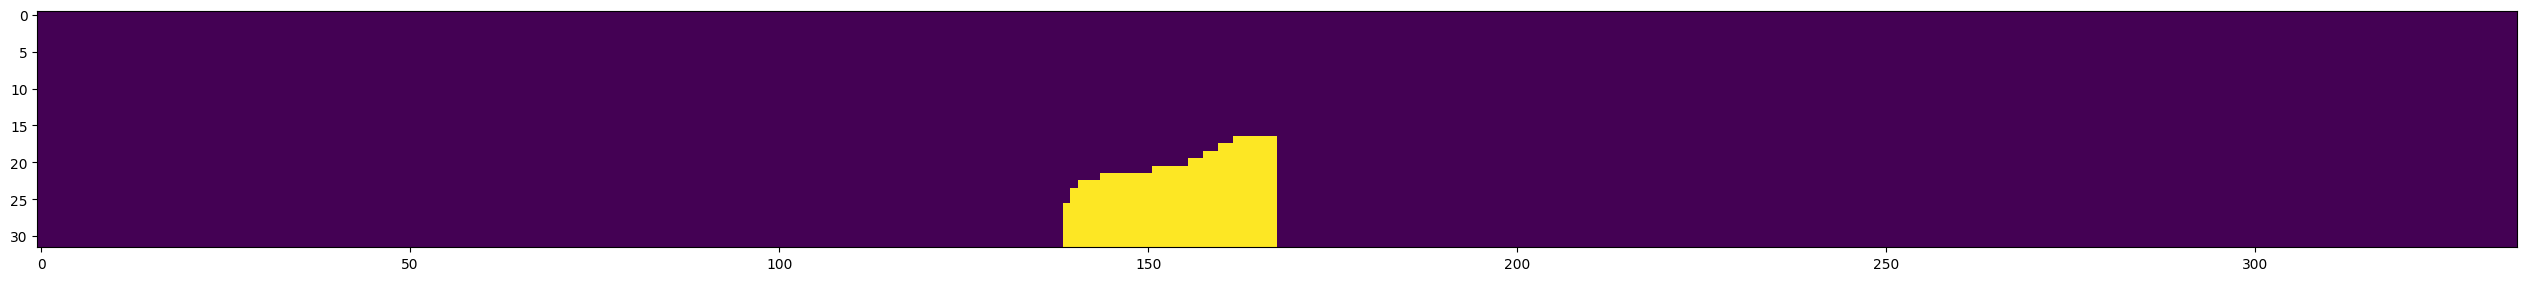

In [24]:
j = 17
i = 1 # i-th obj

res = preds[j]
data = datas[j]
show(np.concatenate([res[i][_] for _ in range(6)], axis=1))
show(torch.concat([data['images'][i][_].cpu() for _ in range(6)], axis=1))
show(torch.concat([data['prompted_objs']['obj_mask'][i][_][:, :, 0].cpu() for _ in range(6)], axis=1))
data['prompted_objs']['obj_prompt'][i]